<a href="https://colab.research.google.com/github/Tinynja/Sarsa-phi-EB/blob/main/notebooks/Sarsa_Phi_EB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

if 'google.colab' in sys.modules:
    !rm -rf *
    !git clone https://github.com/Tinynja/Sarsa-phi-EB
    !mv Sarsa-phi-EB/* .
    !rm -rf Sarsa-phi-EB
    # DON'T install packages defined in Pipfile_Colab_exclude
    !sed -ri "/$(tr '\n' '|' < Pipfile_Colab_exclude)/d" Pipfile
else:
    print('Skipping GitHub cloning since not running in Colab.')

Cloning into 'Sarsa-phi-EB'...
remote: Enumerating objects: 389, done.
remote: Total 389 (delta 0), reused 0 (delta 0), pack-reused 389
Receiving objects: 100% (389/389), 1.88 MiB | 9.08 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [ ]:
# Install required dependencies
import os

if 'google.colab' in sys.modules:
    # Some dependencies required for displaying episode
    !apt install -y python-opengl xvfb 1> /dev/null
    !pip install pyvirtualdisplay 1> /dev/null
    # Colab doesn't support pipenv, hence we convert Pipfile into requirements.txt
    if 'requirements_Colab.txt' not in os.listdir():
        !pip install pipenv
        !pipenv lock -r > requirements.txt
    !pip install -r requirements_Colab.txt 1> /dev/null
else:
    !pipenv install 1> /dev/null



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.0.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Import all supported ROMs into ALE
!ale-import-roms ROMS

[SUPPORTED]              double_dunk ROMS/Double Dunk (Super Basketball) (1989).bin
[SUPPORTED]                    mr_do        ROMS/Mr. Do! (1983).bin
[SUPPORTED]                 crossbow       ROMS/Crossbow (1988).bin
[SUPPORTED]              battle_zone     ROMS/Battlezone (1983).bin
[SUPPORTED]               videochess ROMS/Video Chess (Computer Chess) (1979).bin
[SUPPORTED]                   gopher ROMS/Gopher (Gopher Attack) (1982).bin
[SUPPORTED]                  phoenix        ROMS/Phoenix (1983).bin
[SUPPORTED]                  asterix ROMS/Asterix (AKA Taz) (1983).bin
[SUPPORTED]                    qbert        ROMS/Q. Bert (1983).bin
[SUPPORTED]              donkey_kong    ROMS/Donkey Kong (1982).bin
[SUPPORTED]               mario_bros    ROMS/Mario Bros. (1983).bin
[SUPPORTED]              road_runner    ROMS/Road Runner (1989).bin
[SUPPORTED]                frostbite      ROMS/Frostbite (1983).bin
[SUPPORTED]          elevator_action ROMS/Elevator Action (1983).bin
[SUPPO

In [ ]:
#### ALE-related imports ####

# Built-in libraries
import re
import sys
import timeit
import base64
import pickle
import logging
import subprocess
from pathlib import Path
from datetime import datetime

# Pypi libraries
import gym
import torch
# import numpy as np
import matplotlib.pyplot as plt
from ale_py import ALEInterface, SDL_SUPPORT
import ale_py.roms as ROMS

# Episode display
from PIL import Image
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
Display().start()

# Configuration
CUDA = 'cuda' if torch.cuda.device_count() else 'cpu'
CPU = 'cpu'

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [ ]:
class EnvRecorder:
    def __init__(self, env, out_dir='./results'):
        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(exist_ok=True)
        self.out_dir = self.out_dir.resolve()
        self.env = env

        # Workspace variables
        self.__frame_count_padding = 0
        self.__timestep = 0
    
    def __call__(self, choose_action=None, max_steps=-1, height=300):
        self.record_episode_and_show(choose_action=choose_action, max_steps=max_steps, height=height)
    
    def record_episode_and_show(self, choose_action=None, max_steps=-1, height=300):
        self.record_episode(choose_action=choose_action, max_steps=max_steps)
        self.show_recording(height=height)
    
    def record_episode(self, choose_action=None, max_steps=-1):
        """Generate an episode and record it as record.mp4
        Args:
        choose_action -- callable method that returns the next action based on the current observation
        max_steps     -- maximum number of steps after which force end episode
        """
        choose_action = choose_action or (lambda _: self.env.action_space.sample())

        self._clear_recording()
        self.__timestep, done, observation =  0, False, self.env.reset()
        self._record_frame()
        while not done and self.__timestep != max_steps:
            print(f'\rRecording episode, timestep {self.__timestep+1}...', end='')
            action = choose_action(observation)
            observation, _, done, _ = self.env.step(action)
            self.__timestep += 1
            self._record_frame()

        if self.__timestep == max_steps and not done:
            print('\nWarning: `max_steps` reached before episode terminated')
        else:
            print()

        self._export_as_mp4()

    def show_recording(self, height=300):
        """Show a .mp4 video in html format of the recorded episode"""
        filepath = self.out_dir.joinpath('record.mp4')
        video_b64 = base64.b64encode(filepath.read_bytes())
        html = f'''<video alt="{filepath}" autoplay loop controls style="height:{height}px">
                        <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
                   </video>'''
        ipythondisplay.display(ipythondisplay.HTML(data=html))

    def _clear_recording(self):
        # This is a new episode, delete previously recorded steps
        self.out_dir.joinpath('record').mkdir(exist_ok=True)
        for step_png in self.out_dir.glob('record/step_*.png'):
            step_png.unlink()
        if self.out_dir.joinpath('record.mp4').exists():
            self.out_dir.joinpath('record.mp4').unlink()
    
    def _record_frame(self):
        # Record current timestep png
        img = Image.fromarray(env.render('rgb_array'))
        out_path = self.out_dir.joinpath(f'record/step_{self.__timestep}.png')
        img.save(str(out_path))

    def _export_as_mp4(self):
        """Convert the recorded set of png files into an mp4 video"""
        self._standardize_frame_count_padding()
        in_dir = self.out_dir.joinpath('record')
        in_pattern = f'step_%0{self.__frame_count_padding}d.png'
        out_file = self.out_dir.joinpath('record.mp4')
        !cd $in_dir; ffmpeg -hide_banner -loglevel error -r 60 -i $in_pattern -vcodec libx264 -crf 25 -pix_fmt yuv420p -y $out_file
    
    def _standardize_frame_count_padding(self):
        self.__frame_count_padding = len(str(self.__timestep))
        number_pattern = re.compile('\d+')
        png_abs_glob = 'step_*.png'
        for png_path in self.out_dir.joinpath('record').glob(png_abs_glob):
            ts = int(number_pattern.search(png_path.stem).group(0))
            new_name = png_path.parent.joinpath(f'step_{ts:0{self.__frame_count_padding}d}.png')
            png_path.rename(new_name)

In [ ]:
def cbrt(x):
    if x >= 0:
        return x**(1/3)
    else:
        return -(-x)**(1/3)


class features:
    @staticmethod
    def basic(frame, palette, background, crop_size=torch.Tensor([15,10]), flatten=True):
        # For each color in palette, tell if each pixel is that color (e.g. 210,160,128)
        colors_in_pixels = ((frame-background).unsqueeze(-2) == palette).all(-1)
        # Split the image into n tiles, each with dimension `crop_size` (e.g. 14,16,15,10,128)
        cropped_colors_in_pixels = torch.stack(torch.stack(colors_in_pixels.split(crop_size[1],dim=-2)).split(crop_size[0],dim=-3))
        # Apply logical or inside each cropped image (e.g. 14,16,128)
        cropped_features = cropped_colors_in_pixels.any(3).any(2)
        # Flatten the features (e.g. 28672)
        return cropped_features.flatten() if flatten else cropped_features
    
    @staticmethod
    def b_pros(frame, palette, background, crop_size=torch.Tensor([15,10])):
        raise NotImplementedError()
        basic_features = features.basic(frame, palette, background, crop_size=crop_size)
        b_pros_features = torch.combinations(basic_features)
        return b_pros_features
    
    @staticmethod
    def discretized_float(number, low, high, n_intervals):
        feature = torch.zeros(n_intervals+2, dtype=torch.bool)
        if number < low:
            feature[0] = True
        elif number >= high:
            feature[-1] = True
        else:
            index = int( n_intervals/2 * ( 1 + cbrt( (number-(high+low)/2) / ((high-low)/2) ) ) )
            feature[index+1] = True
        return feature

In [ ]:
class BinaryEnv:
    def __init__(self, env_name, n_features, device=CUDA, *args, **kwargs):
        self.env = gym.make(env_name, *args, **kwargs)
        self.n_features = int(n_features/self.env.observation_space.shape[0])
        self.device = device

        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

        self._overwrite_obs_high_low()
    
    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        return self._binarize_observation(observation)

    def step(self, *args, **kwargs):
        observation, reward, done, info = self.env.step(*args, **kwargs)
        observation = self._binarize_observation(observation)
        return observation, reward, done, info

    def render(self, *args, **kwargs):
        return self.env.render(*args, **kwargs)
    
    def _overwrite_obs_high_low(self):
        if self.env.spec.id.startswith('CartPole'):
            self.env.observation_space.low[[1,3]] = -4, -7
            self.env.observation_space.high[[1,3]] = 4, 7
    
    def _binarize_observation(self, observation):
        bin_features = []
        lows, highs = self.env.observation_space.low, self.env.observation_space.high
        for i,obs in enumerate(observation):
            bin_features.append(features.discretized_float(obs, lows[i], highs[i], n_intervals=self.n_features))
        return torch.cat(bin_features).to(self.device)

In [ ]:
from gym.spaces import Discrete, Box

class EnvALE:
    def __init__(self, rom, out_dir='results', seed=0, feature_type='ScreenRGB',
                 regen_bg=False, bg_samples=18000, device=CUDA):
        self.rom = rom
        self.rom_name = rom.stem
        self.feature_type = feature_type
        self.device = device

        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(exist_ok=True)
        self.out_dir = self.out_dir.resolve()

        # ALE
        self.ale = ALEInterface()
        self.ale.setInt("random_seed", seed)
        self.ale.loadROM(rom)

        # gym action_space compatibility
        action_set = self.ale.getMinimalActionSet()
        self.action_space = Discrete(len(action_set))
        self.action_space.action_set = action_set

        # color palette
        self.color_palette = self._get_color_palette().to(self.device)

        self._bg_path = Path(f'./backgrounds/{self.rom_name}.pickle')
        if regen_bg or not self._bg_path.exists() or not self._bg_path.is_file():
            self.background = self._get_background(n_samples=bg_samples)
        else:
            with open(self._bg_path, 'rb') as file:
                self.background = pickle.load(file).to(self.device)
        
        self._set_observe_method(feature_type)
        self.observation_space = Box(low=0, high=1, shape=self._observe().shape, dtype=bool)

    def reset(self, do_record=False):
        self.ale.reset_game()
        observation = self._observe()
        
        return observation
        
    def step(self, action):
        if isinstance(action, int):
            action = self.action_space.action_set[action]

        reward = self.ale.act(action)
        observation = self._observe()
        done = self.ale.game_over()
                
        return observation, reward, done, None

    def render(self, mode='rgb_array'):
        if mode == 'rgb_array':
            return self.ale.getScreenRGB()
        else:
            raise ValueError(f'render mode `{mode}` is not supported')

    def _set_observe_method(self, feature_type):
        if feature_type == 'ScreenRGB':
            self._observe = lambda: torch.from_numpy(self.ale.getScreenRGB()).to(self.device)
        elif feature_type == 'ScreenGrayscale':
            self._observe = lambda: torch.from_numpy(self.ale.getScreenGrayscale()).to(self.device)
        elif feature_type == 'Basic':
            self._observe = lambda: features.basic(frame=torch.from_numpy(self.ale.getScreenRGB()).to(self.device),
                                                   palette=self.color_palette,
                                                   background=self.background)
        elif feature_type == 'B-PROS':
            self._observe = lambda: features.b_pros(frame=torch.from_numpy(self.ale.getScreenRGB()).to(self.device),
                                                    palette=self.color_palette,
                                                    background=self.background)
        else:
            raise NotImplementedError(f'Feature type `{feature_type}` is not supported')
        
    def _observe(self):
        raise NotImplementedError()
    
    def _get_color_palette(self):
        result = subprocess.run(['python', '-c', f'__import__("ale_py").ALEInterface().loadROM("{str(self.rom)}")'], capture_output=True)
        palette_name = result.stderr.decode().splitlines()[6].strip().split()[-1]
        with open(f'palettes/{palette_name}_Palette.pickle', 'rb') as file:
            palette = pickle.load(file)
        return palette
    
    def _get_background(self, n_samples):
        bg_feature_type = 'ScreenRGB' if self.feature_type not in ['ScreenGrayscale',] else 'ScreenGrayscale'
        self._set_observe_method(bg_feature_type)
        
        sample_i = 0
        pixel_histogram = torch.zeros((*self.ale.getScreenDims(), self.color_palette.shape[0]), dtype=torch.int32).to(self.device)
        while sample_i < n_samples:
            done, observation = False, self.reset()
            while not done and sample_i < n_samples:
                if not sample_i%10:
                    print(f'\rGenerating background... {sample_i}/{n_samples} samples ({sample_i/n_samples:.0%})', end='')
                action = self.action_space.sample()
                observation, reward, done, info = self.step(action)
                colors_in_pixels = (observation.unsqueeze(-2) == self.color_palette).all(-1)
                pixel_histogram += colors_in_pixels
                sample_i += 1
        print('\r', end='')
        background_ids = pixel_histogram.argmax(axis=-1)
        background = self.color_palette[background_ids]
        
        self._bg_path.parent.mkdir(exist_ok=True)
        with open(self._bg_path, 'wb') as file:
            pickle.dump(background.cpu(), file)
        
        return background

In [ ]:
#@title

if print("Skipped background regeneration."):
# if True:

    from ale_py.roms import *
    games_to_generate_bg = [Breakout, MontezumaRevenge, Venture, Qbert, Frostbite, Freeway]

    for game in games_to_generate_bg:
        print(f'\n{game.stem}')
        env = EnvALE(game, regen_bg=True, bg_samples=100)
        bg_np = env.background.cpu().to(torch.uint8).numpy()
        display(Image.fromarray(bg_np))

Skipped background regeneration.


In [ ]:
#@title

if print("Skipped displaying stored backgrounds to reduce ouptuts."):
# if True:

    for filepath in Path('backgrounds').iterdir():
        print(f'\nBackground in `{filepath.resolve()}`')
        with open(filepath, 'rb') as file:
            bg = pickle.load(file)
        display(Image.fromarray(bg.to(torch.uint8).numpy()))

Skipped displaying stored backgrounds to reduce ouptuts.


In [ ]:
#@title

if print("Skipped manual test."):
# if True:

    env = EnvALE(ROMS.Breakout)
    recorder = EnvRecorder(env)
    recorder()

Skipped manual test.


In [ ]:
from math import ceil

class PrintJustEnough:
    def __init__(self, time_interval=0.5):
        self._print_interval = 1
        self._print_count = 0
        self.time_interval = time_interval
        self._calibrated = False
        self.reset_calibration()
    
    def reset_calibration(self):
        self._calib_start = None
        self._calib_count = 0
        self._calibrated = False
    
    def print(self, *args, **kwargs):
        if self._calibrated:
            self._print_count += 1
            if not self._print_count%self._print_interval:
                print(*args, **kwargs)
                self._print_count = 0
        else:
            self._handle_calibration()
        
    def _handle_calibration(self):
        self._calib_count += 1
        curr_time = timeit.default_timer()
        if self._calib_start is None:
            self._calib_start = curr_time
        if curr_time-self._calib_start > 1:
            self._print_interval = ceil(self.time_interval*self._calib_count/(curr_time-self._calib_start))
            self._calibrated = True
    
    def __call__(self, *args, **kwargs):
        self.print(*args, **kwargs)

pje = PrintJustEnough()

In [ ]:
class SarsaPhiEBAgent:
    def __init__(self, env, gamma=0.99, epsilon=0.01, alpha=0.5, lam=0.9, beta=0.05, init_action=1, step_repeat_count=1, device=CUDA, debug=False):
        """An agent using Sarsa(lambda) algorithm with:
            - Linear Function Approximation (SGD)
            - Replacing Traces
            - Exploration-Bonus
        
        Args:
                      env -- gym-like environment
                    alpha -- step size
                    gamma -- discount factor
                      lam -- trace decay
                     beta -- exploration bonus parameter
              init_action -- action to take after an environment reset
        step_repeat_count -- numer of times to repeat an action every timestep (under-the-hood) 
                   device -- device on which to store tensors
                    debug -- enable debug output
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.lam = lam
        self.beta = beta
        self.init_action = init_action
        self.step_repeat_count = step_repeat_count
        self.device = device

        self.__log = logging.Logger(name=self.__class__.__name__,
                                    level=(logging.DEBUG if debug else logging.WARNING))

        # Workspace variables
        self.feature_space_shape = (self.env.action_space.n, *self.env.reset().shape)
        self.weights = torch.zeros(self.feature_space_shape).to(self.device)
        self._counts = torch.zeros(self.feature_space_shape).to(self.device)
        self._total_steps = 0
        self.rewards = []

    def learn(self, n_steps):
        start_time, total_rewards, done = timeit.default_timer(), 'INIT', True
        pje.reset_calibration()
        i = 0
        while len(self.rewards) < n_steps:
            # Information display
            avg_time = (timeit.default_timer()-start_time)/(i or 1)
            #pje(f'\rSarsaPhiEB learning iteration {self._total_steps}/{self._total_steps-i+n_steps} ({1000*avg_time:.2f}ms/iter, remaining {(n_steps-i)*avg_time:.0f}s)    ', end='')

            # Reset env when episode ends
            if done:
                if total_rewards != 'INIT':
                    self.rewards.append(float(total_rewards))
                next_phi = self.env.reset()
                total_rewards = 0
                if self.init_action is not None:
                    next_phi, reward, done, _ = self.env.step(self.init_action)
                    total_rewards += reward
                next_action = self._choose_action(next_phi)
                traces = torch.zeros(self.feature_space_shape).to(self.device)

            # Advance to next timestep
            phi, action = next_phi, next_action
            active_features = phi.nonzero()
            self._total_steps += 1

            # Take an action
            next_phi, reward, done, _ = self._step_repeat(action)
            next_action = self._choose_action(next_phi)
            total_rewards += reward

            # Apply exploration bonus
            self._counts[action,active_features] += 1
            reward += self._calc_exploration_bonus(phi, action)

            # RL Algorithm : Sarsa(lambda) LFA(SGD) Replacing Traces
            traces *= self.gamma * self.lam
            traces[action, active_features] = phi[active_features].to(traces.dtype)
            if not done:
                delta = reward + self.gamma * self._action_value(next_phi, next_action) - self._action_value(phi, action)
            else:
                # In terminal state, all state-action values are 0
                delta = reward + 0 - self._action_value(phi, action)
            if self.alpha * delta * traces.isnan().any():
                # print(self.weights.unique())
                print(self._action_value(phi, action))
                # print(phi)
                # print(action)
                # print(traces.unique())
            self.weights += self.alpha * delta * traces

            # print('traces', traces.nonzero())
            # __import__('time').sleep(1)
            # return locals()
            # if reward > 0:
            #     print(f'ITERATION {i}')
            #     print('REWARD', reward)
            #     # return self.weights, phi
            # if self.weights.max() > 1:
            #     print(f'ITERATION {i}')
            #     print('alpha', self.alpha)
            #     print('delta', delta)
            #     print('reward', reward)
            #     print('weight_sum', self.weights[action].sum())
            #     print('next_action_value', self._action_value(phi, action))
            #     print('action_value', self._action_value(next_phi, next_action))
            #     # print(traces.unique())
            #     # print(self.weights[action].unique().sum())
            #     break
        
        #print(f'\rSarsaPhiEB learning iteration {self._total_steps}/{self._total_steps-i+n_steps-1} ({1000*avg_time:.2f}ms/iter, remaining {(n_steps-i)*avg_time:.0f}s)    ', end='')
        #print(f'\nTotal elapsed time: {datetime.utcfromtimestamp(timeit.default_timer()-start_time).strftime("%H:%M:%S.%f")}')
    
    def _step_repeat(self, action):
        reward = 0
        for i in range(self.step_repeat_count):
            observation, sub_reward, done, info = self.env.step(action)
            reward += sub_reward
            if done: break
        return observation, reward, done, info
    
    def _action_value(self, phi, action):
        # if (self.weights[action]@phi.to(self.weights.dtype)).isinf():
        #     print(self.weights[action].unique())
        #     print(phi.to(self.weights.dtype))
            # print(self._action_value(phi, action))
            # print(self._action_value(next_phi, next_action))
        return (self.weights[action]@phi.to(self.weights.dtype)).item()
    
    def _choose_action(self, phi):
        if torch.rand(1) > self.epsilon:
            action_values = self.weights@phi.to(self.weights.dtype)
            best_actions = (action_values == action_values.max()).nonzero()
            # Tie-breaker
            action = best_actions[torch.randint(len(best_actions), (1,))]
            return action.item()
        else:
            return self.env.action_space.sample()
    
    def _calc_exploration_bonus(self, phi, action):
        # Compute the exploration bonus
        phi_occ = torch.cat((self._counts[action, phi], self._total_steps-self._counts[action, ~phi])).to(self.device)
        rho = ((phi_occ+1/2) / (self._total_steps+1)).prod()
        rho_prime = ((phi_occ+1+1/2) / (self._total_steps+1+1)).prod()
        pseudocount = (rho*(1-rho_prime)) / (rho_prime-rho)
        exploration_bonus = self.beta / pseudocount.sqrt()
        if torch.isnan(exploration_bonus) or torch.isinf(exploration_bonus):
          exploration_bonus = 1
        #print(exploration_bonus)
        return exploration_bonus
    


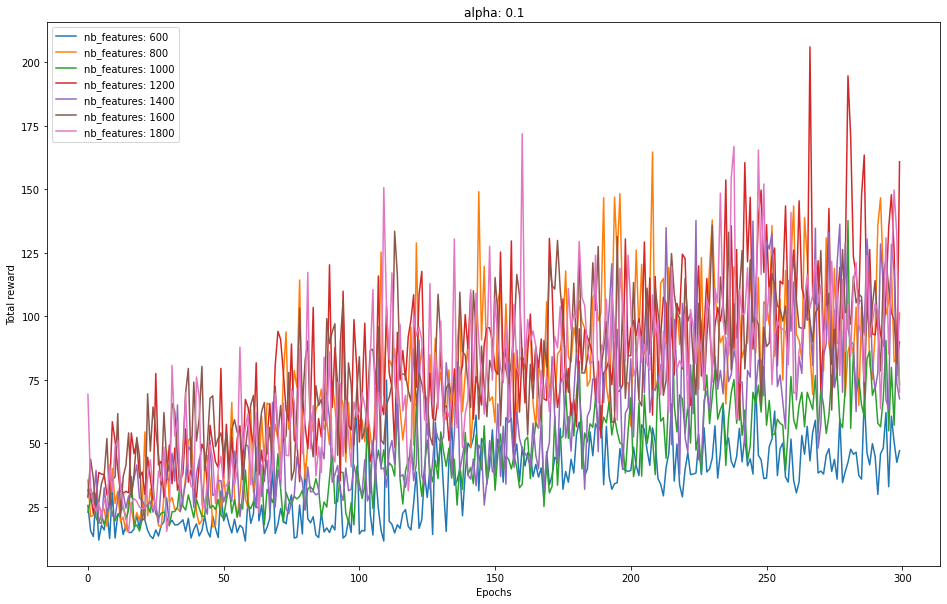

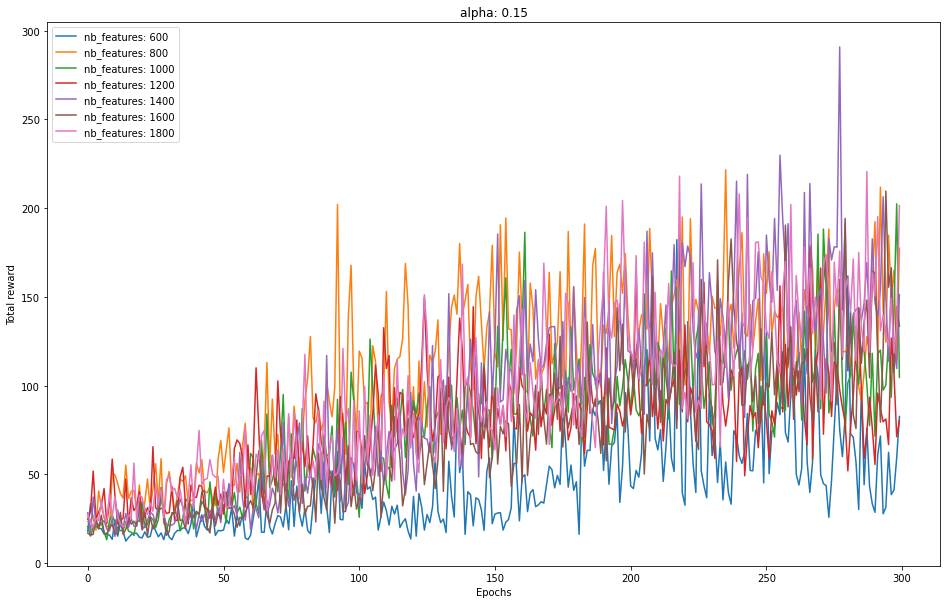

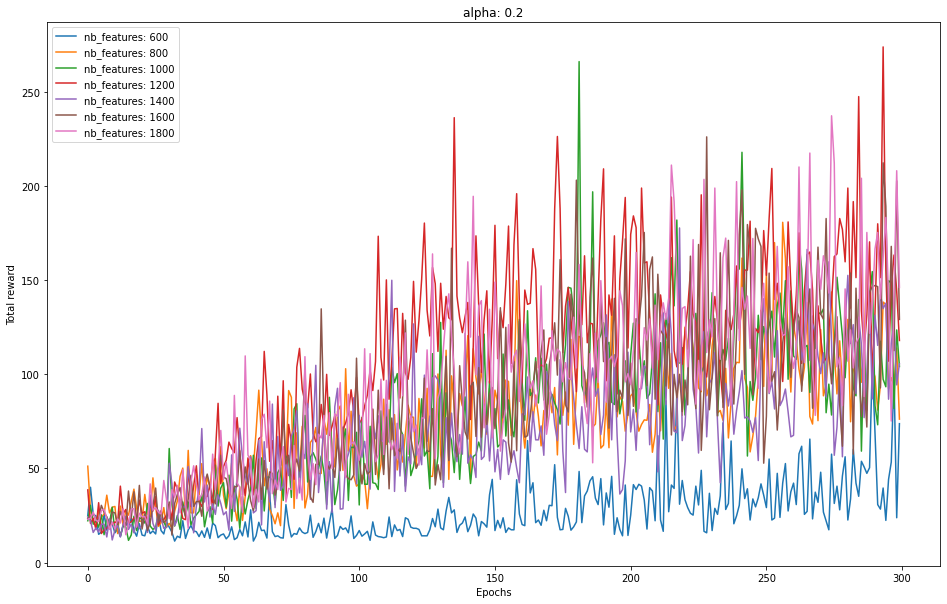

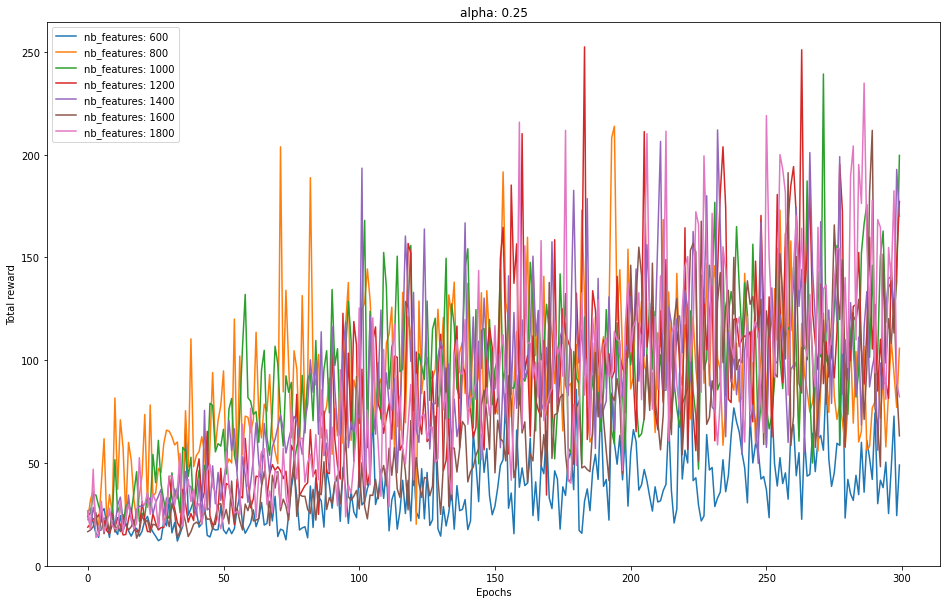

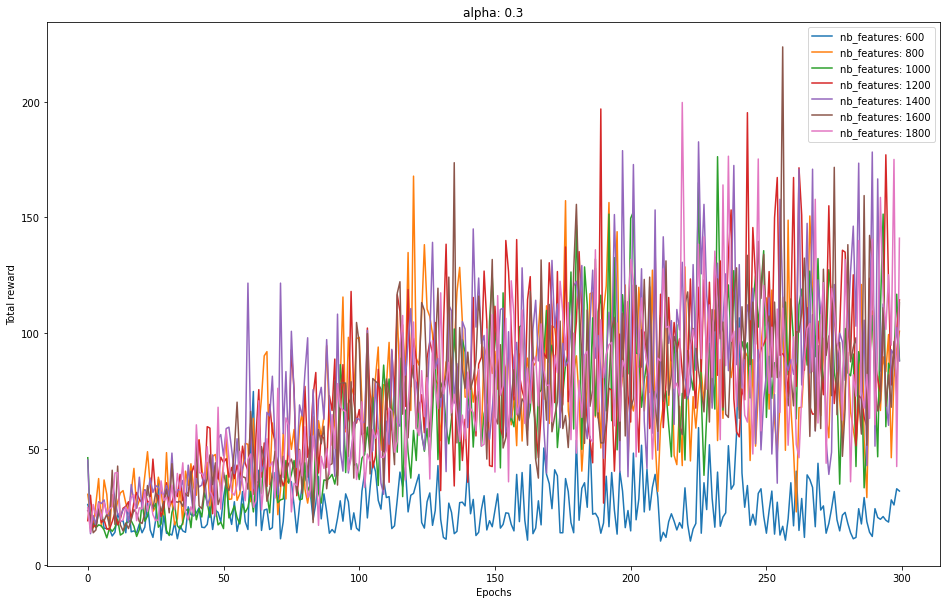

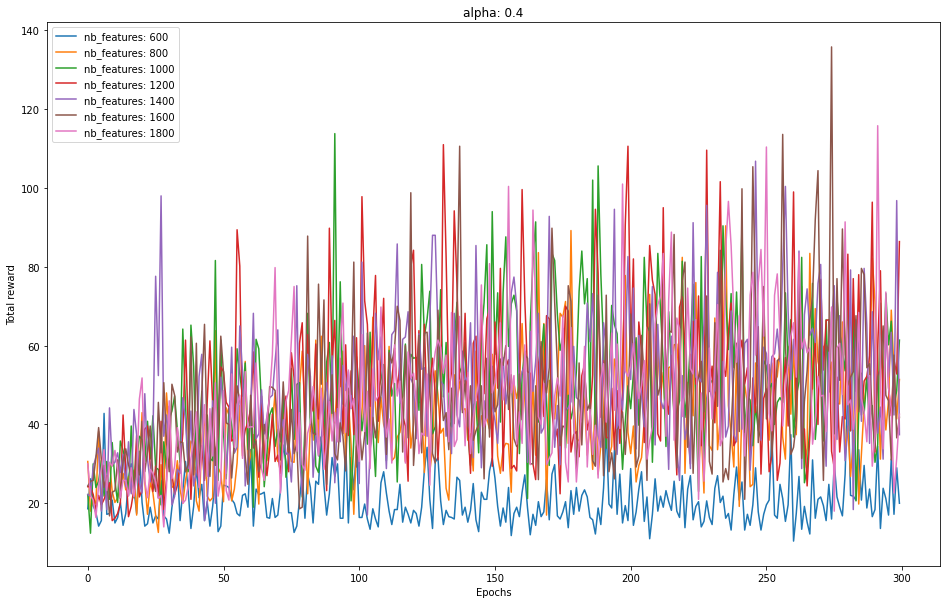

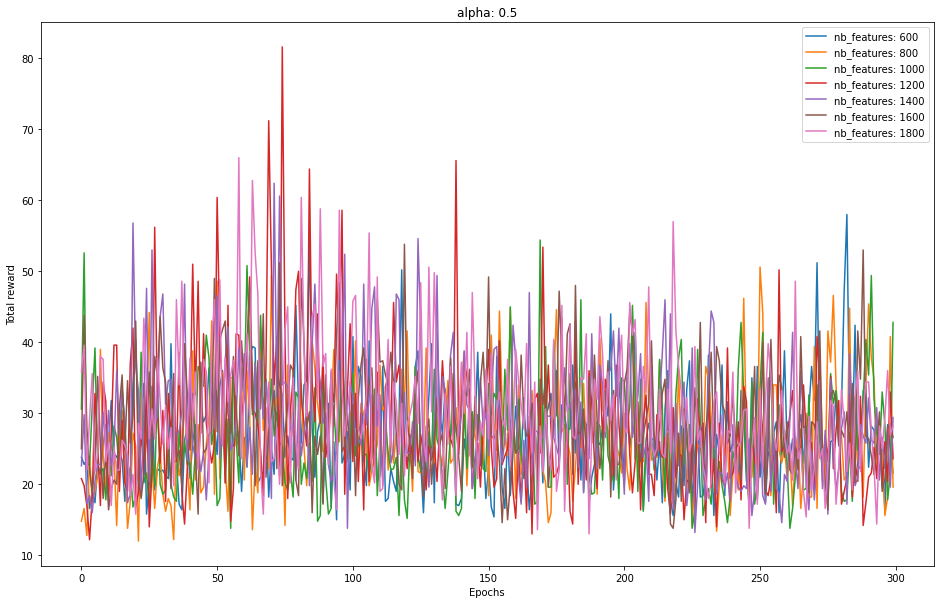

[[ 45.028  68.316  42.52   49.28   22.224  22.172  27.888]
 [100.088 138.576 110.5    91.484  79.9    49.572  28.156]
 [ 67.256 112.608 117.304 117.56   89.704  51.764  26.848]
 [117.788  95.24  149.856 126.732 102.04   52.34   25.492]
 [ 94.744 155.136 108.132 114.344  97.728  57.82   24.876]
 [100.88  124.116 121.96  110.152  94.544  56.976  28.16 ]
 [100.04  146.088 138.888 140.004  93.412  53.192  27.012]]
[4] [1]


In [ ]:
# env = BinaryEnv('CartPole-v1', n_features=4000)
# agent = SarsaPhiEBAgent(env)
# ret = agent.learn(1)
# env.reset().nonzero()
import numpy as np



test_alphas =  [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
test_features = [600, 800, 1000, 1200, 1400, 1600, 1800]
epochs = 300
timesteps = range(epochs)
grid = np.zeros((len(test_features),len(test_alphas),epochs))
nb_of_runs = 5
plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()

for i,alpha in enumerate(test_alphas):
  for j,nb_features in enumerate(test_features):
    rewards =  [[]]*nb_of_runs
    for k in range(nb_of_runs): #add repetition to lower variance (make graphs more readable)
      env = BinaryEnv('CartPole-v1', n_features=nb_features, device=CPU)
      agent = SarsaPhiEBAgent(env, alpha=alpha, device=env.device)
      # recorder()
      agent.learn(epochs)
      rewards[k] = (agent.rewards)
    grid[j,i] = np.mean(np.array(rewards),axis=0)
    plt.plot(timesteps, torch.mean(torch.as_tensor(rewards),dim=0),label='nb_features: '+ str(nb_features))
  
  plt.legend()
  plt.title('alpha: ' + str(alpha))
  plt.xlabel('Epochs')
  plt.ylabel('Total reward')
  plt.show()
avg = np.mean(grid[:,:,-50:], axis=2)
print(avg)
[best_features,best_alpha] = np.where(avg == avg.max())
print(best_features,best_alpha)

In [ ]:
with open('third_grid_search.pickle', 'wb') as file:
    pickle.dump(avg,file)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


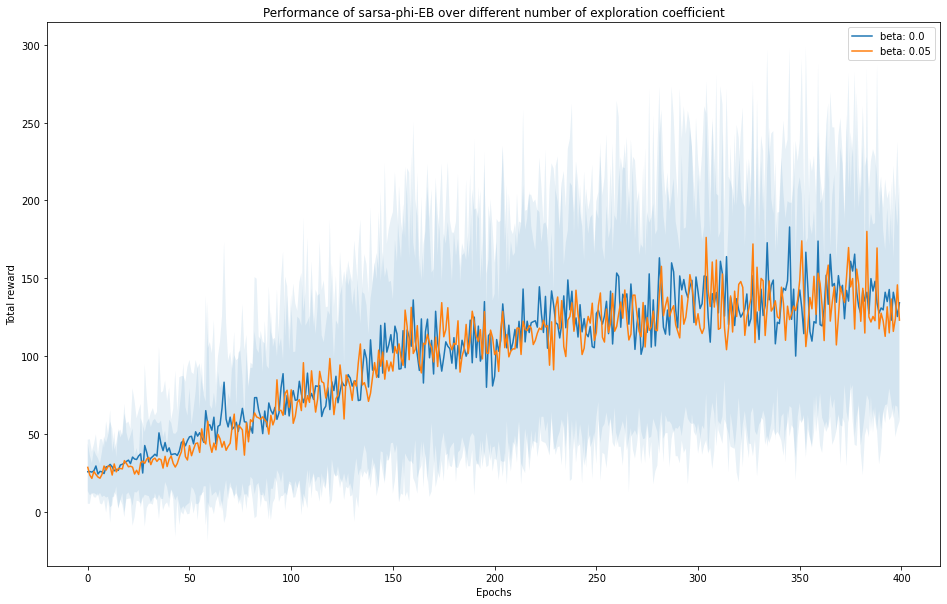

[137.92066667 135.40533333]
[0]


In [ ]:
import numpy as np
nb_features, alpha = [1600, 0.2] #found in previous grid search
#nb_features, alpha = [1200, 0.15] #found ingrid search 2

def plot_many(experiments, label=None, color=None):
  mean_exp = np.mean(experiments, axis=0)
  std_exp = np.std(experiments, axis=0)
  plt.plot(mean_exp, color=color, label=label)
  plt.fill_between(range(len(experiments[0])), mean_exp + std_exp, mean_exp - std_exp, color=color, alpha=0.1)

test_betas =  [0.0, 0.05]
epochs = 400
timesteps = range(epochs)
beta_grid = np.zeros((len(test_betas),epochs))
nb_of_runs = 30
plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()


for j,beta in enumerate(test_betas):
  rewards =  [[]]*nb_of_runs
  for k in range(nb_of_runs): #add repetition to lower variance (make graphs more readable)
    env = BinaryEnv('CartPole-v1', n_features=nb_features, device=CPU)
    agent = SarsaPhiEBAgent(env, alpha=alpha, beta = beta, device=env.device)
    # recorder()
    agent.learn(epochs)
    rewards[k] = (agent.rewards)
    print(k)
  beta_grid[j] = np.mean(np.array(rewards),axis=0)
  plot_many(np.array(rewards), label='beta: ' + str(beta))
  #plt.plot(timesteps, torch.mean(torch.as_tensor(rewards),dim=0),label='beta: ' + str(beta))
  
  
plt.legend()
plt.title('Performance of sarsa-phi-EB over different exploration coefficients')
plt.xlabel('Epochs')
plt.ylabel('Total reward')
plt.show()
beta_avg = np.mean(beta_grid[:,-50:], axis=1)
print(beta_avg)
[best_beta] = np.where(beta_avg == beta_avg.max())
print(best_beta)

In [ ]:
agent = SarsaPhiEBAgent(env, alpha=alpha, beta = 10.0, device=env.device)
# recorder()
agent.learn(epochs)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
tensor(2.0179)
tensor(2.3145)
tensor(2.3753)
tensor(3.5600)
tensor(2.3896)
tensor(2.2118)
tensor(2.2447)
tensor(2.4218)
tensor(3.1143)
tensor(2.2882)
tensor(2.4662)
tensor(2.3633)
tensor(2.4257)
tensor(2.3539)
tensor(3.4036)
tensor(2.8171)
tensor(3.2274)
tensor(2.3115)
tensor(2.5747)
tensor(2.6320)
tensor(3.2405)
tensor(2.5410)
tensor(2.7727)
tensor(2.6036)
tensor(2.8439)
tensor(2.4894)
tensor(2.6340)
tensor(2.2526)
tensor(2.4428)
tensor(2.3554)
tensor(2.3591)
tensor(2.4011)
tensor(2.3409)
tensor(2.5316)
tensor(2.0457)
tensor(2.5523)
tensor(2.0807)
tensor(3.2179)
tensor(2.2990)
tensor(2.9458)
tensor(2.6598)
tensor(2.6071)
tensor(2.7065)
tensor(2.5953)
tensor(2.1516)
tensor(2.3668)
tensor(2.5272)
tensor(2.1125)
tensor(3.3162)
tensor(2.1366)
tensor(3.1514)
tensor(2.0613)
tensor(2.5926)
tensor(2.7094)
tensor(2.5533)
tensor(3.3936)
tensor(2.5617)
tensor(3.3259)
tensor(2.4126)
tensor(2.6449)
tensor(3.0739)
tensor(

KeyboardInterrupt: ignored